theta: 0.002638050790818939
mean: 103.16438717948718
variance: 9.97182026807513


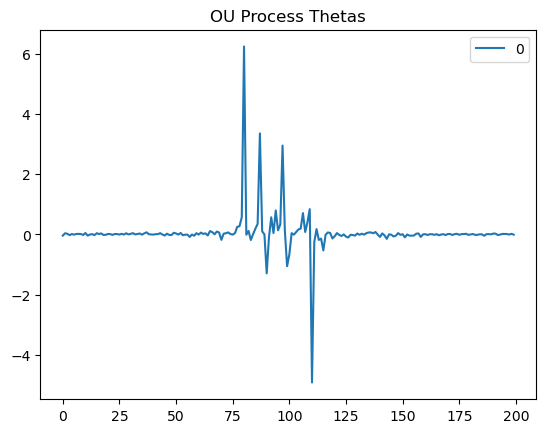

In [7]:
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

spreads = pd.read_pickle('../data/spreads.pkl')
mean = spreads.mean()

def calibrate_ou():
    # assuming long-term mean is the same
    # the short term mean of our sample

    thetas = []
    for index, x in enumerate(spreads):
        if index == 0:
            continue

        prev_x = spreads[index - 1]

        theta = (-x + prev_x) / (math.e * (prev_x - mean))
        thetas.append(theta)

        return thetas


def log(n):
    abs_n = abs(n)
    if n < 0:
        return math.log(abs_n)
    elif n == 0:
        return 0

    return math.log(abs_n)


thetas = calibrate_ou()
d = list(map(lambda t: log(t), thetas))

data = pd.DataFrame(data=thetas[0:200])
sns.lineplot(data=data).set(title='OU Process Thetas')

theta = sum(thetas) / len(thetas)
print(f'theta: {theta}')
print(f'mean: {mean}')

# calculate variance
variance = spreads.var()
print(f'variance: {variance}')

plt.show()